# Bayesian Cross Sectional Models

This notebook investigates the fit and parameter estimates of Bayesian models. We try the following three distributions:
- Pareto
- Weibull
- Generalised Pareto

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import dill
import os

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
# Self made modules
from thesis_tools.utils.data import *
from thesis_tools.utils.model_fitting import *
from thesis_tools.statistical_tests.tests import *
from thesis_tools.models.bayesian_univariate_cross_sectional import *
from thesis_tools.models.bayesian_multivariate_cross_sectional import *

## Estimation

In [4]:
df = read_panel_data(observations_threshold=0)
len(df)

406

In [5]:
groups = df['group'].unique()
for group in groups:
    for model_type in ['Pareto', 'Weibull', 'GeneralisedPareto']:
        train_or_retrieve_regularised_cross_sectional_model(
            panel_df=df,
            group=group,
            model_type=model_type,
            retrain_if_saved=False
        )

## Evaluation

### Prior Predictive Checks

### Fit

We evaluate the fit similarly to the way we evaluated the fit for frequentist models:
- Kolmogorov-Smirnof Test
- Anderson-Darling Test
- Cramer- von Mises Test

In [6]:
path = "../../Stored_Results/bayesian_cross_sectional_regularised/test_df.pkl"
rebuild = False
if os.path.exists(path) and not rebuild:
    with open(path, 'rb') as f:
        test_df = dill.load(f)
else:
    test_dict = {}
    for group in groups:
        for model_type in ['Pareto', 'Weibull', 'GeneralisedPareto']:
            print(f"Testing {group} using {model_type} distribution")
            model = train_or_retrieve_regularised_cross_sectional_model(
                panel_df=df,
                group=group,
                model_type=model_type,
                retrain_if_saved=False
            )
            post_pred_df = model.posterior_predictive()
            years = df[df['group'] == group]['year'].unique()
            for year in years:
                post_pred = post_pred_df[f'y_{year}']
                true_data = np.array(df[(df['group'] == group) & (df['year'] == year)]['net_worth'].values[0])
                ks_stat, ks_pval = Kolmogorov_Smirnov_two_sample_test(data1=post_pred, data2=true_data)
                _, cm_stat = Anderson_Darling_statistic(data_1=post_pred, data_2=true_data, weight_function='Cramer-von Mises')
                _, ad_stat = Anderson_Darling_statistic(data_1=post_pred, data_2=true_data, weight_function='Anderson-Darling')
                test_dict[(year, group, model_type)] = {'KS_stat': ks_stat, 'KS_pval': ks_pval, 'CM_stat': cm_stat, 'AD_stat': ad_stat}
    test_df = pd.DataFrame(test_dict).T
    test_df.index.names = ['year', 'group', 'model_type']
    with open(path, 'wb') as f:
        dill.dump(test_df, f)

In [7]:
test_df

,,,KS_stat,KS_pval,CM_stat,AD_stat
year,group,model_type,,,,
1999,Alps,Pareto,0.629900,0.740326,0.134844,1.348439e+08
2000,Alps,Pareto,0.556800,0.886511,0.058434,5.843441e+07
2001,Alps,Pareto,0.351643,0.281258,0.038419,3.841890e+07
2002,Alps,Pareto,0.472500,0.094554,0.010469,1.046892e+07
2003,Alps,Pareto,0.244643,0.713778,0.019202,1.920216e+07
...,...,...,...,...,...,...
2018,U.S.,GeneralisedPareto,0.082230,0.001051,0.013136,1.941708e+05
2019,U.S.,GeneralisedPareto,0.064014,0.017525,0.009463,9.687972e+04
2020,U.S.,GeneralisedPareto,0.058702,0.035349,0.005702,3.194284e+05


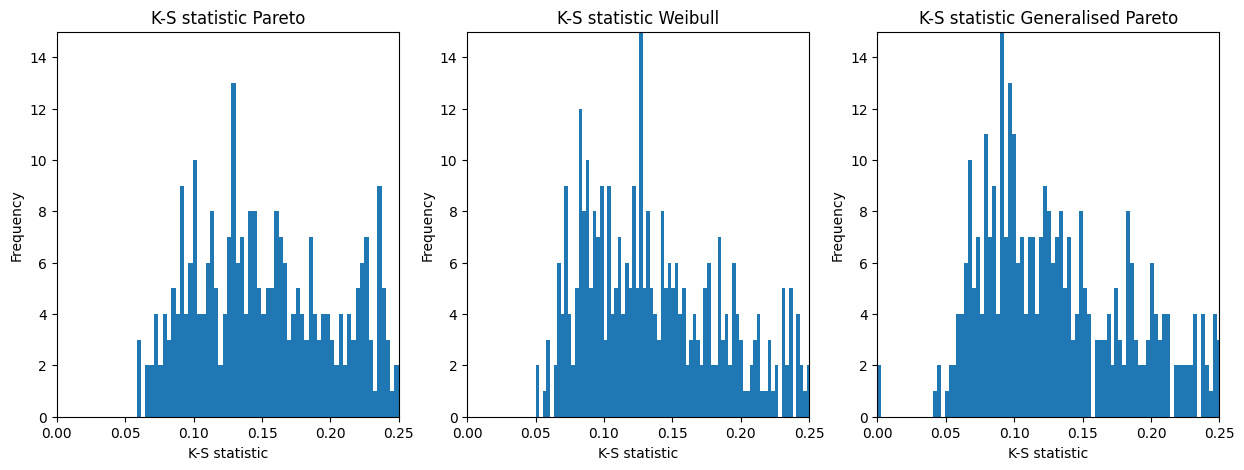

In [20]:
# Plot the K-S stats for the 3 distributions next to each other
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
x_lb, x_ub = 0.00, 0.25
y_lb, y_ub = 0, 15
n_bins = 300
ax[0].hist(test_df.xs('Pareto', level='model_type')['KS_stat'], bins=n_bins)
ax[0].set_xlim(x_lb, x_ub)
ax[0].set_ylim(y_lb, y_ub)
ax[0].set_xlabel('K-S statistic')
ax[0].set_ylabel('Frequency')
ax[0].set_title('K-S statistic Pareto')
ax[1].hist(test_df.xs('Weibull', level='model_type')['KS_stat'], bins=n_bins)
ax[1].set_xlim(x_lb, x_ub)
ax[1].set_ylim(y_lb, y_ub)
ax[1].set_xlabel('K-S statistic')
ax[1].set_ylabel('Frequency')
ax[1].set_title('K-S statistic Weibull')
ax[2].hist(test_df.xs('GeneralisedPareto', level='model_type')['KS_stat'], bins=n_bins)
ax[2].set_xlim(x_lb, x_ub)
ax[2].set_ylim(y_lb, y_ub)
ax[2].set_xlabel('K-S statistic')
ax[2].set_ylabel('Frequency')
ax[2].set_title('K-S statistic Generalised Pareto')
plt.show()


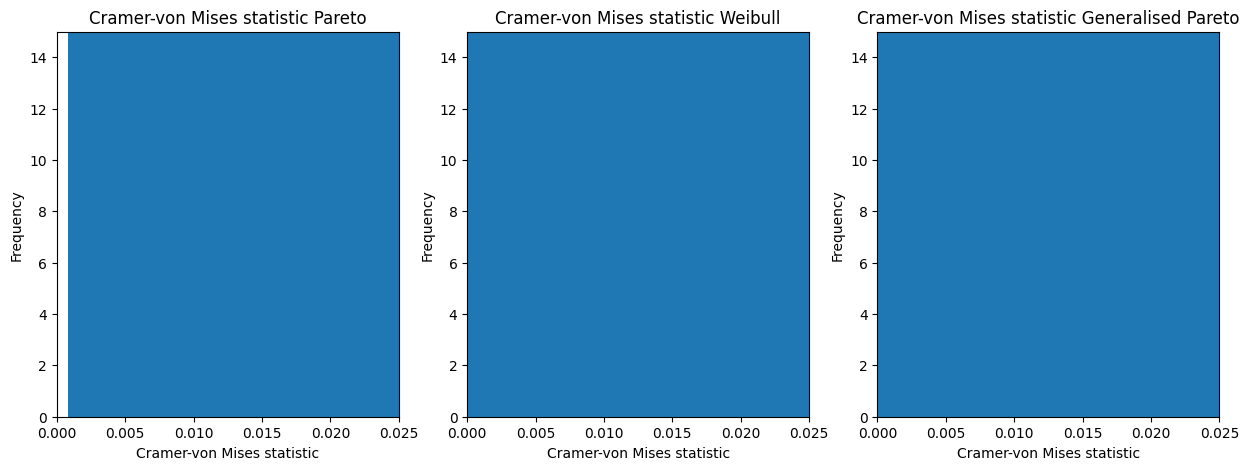

In [9]:
# Do the same for the Cramer-von Mises statistic
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
x_lb, x_ub = 0.00, 0.025
y_lb, y_ub = 0, 15
n_bins = 50
ax[0].hist(test_df.xs('Pareto', level='model_type')['CM_stat'], bins=n_bins)
ax[0].set_xlim(x_lb, x_ub)
ax[0].set_ylim(y_lb, y_ub)
ax[0].set_xlabel('Cramer-von Mises statistic')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Cramer-von Mises statistic Pareto')
ax[1].hist(test_df.xs('Weibull', level='model_type')['CM_stat'], bins=n_bins)
ax[1].set_xlim(x_lb, x_ub)
ax[1].set_ylim(y_lb, y_ub)
ax[1].set_xlabel('Cramer-von Mises statistic')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Cramer-von Mises statistic Weibull')
ax[2].hist(test_df.xs('GeneralisedPareto', level='model_type')['CM_stat'], bins=n_bins)
ax[2].set_xlim(x_lb, x_ub)
ax[2].set_ylim(y_lb, y_ub)
ax[2].set_xlabel('Cramer-von Mises statistic')
ax[2].set_ylabel('Frequency')
ax[2].set_title('Cramer-von Mises statistic Generalised Pareto')
plt.show()

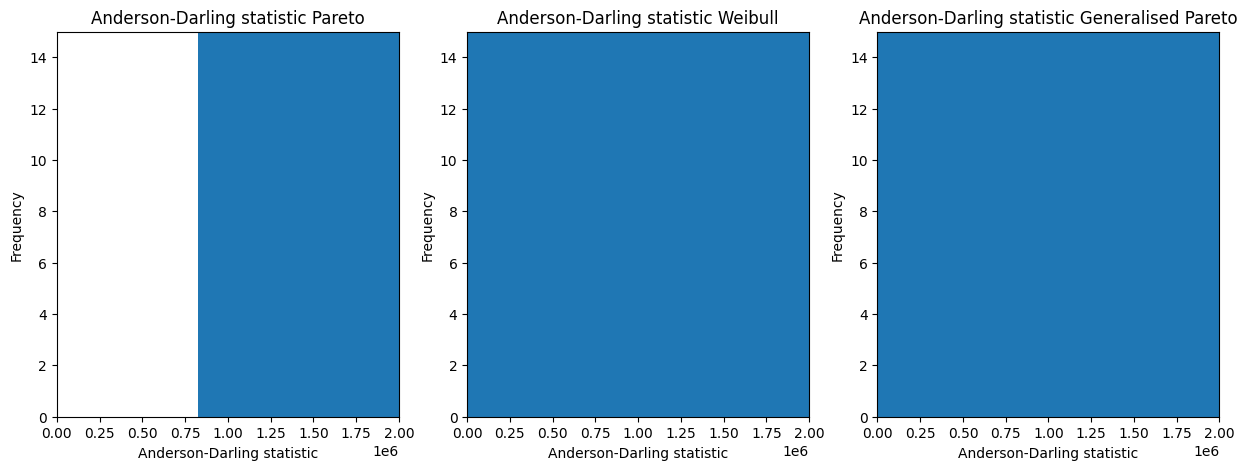

In [10]:
# Do the same for the Anderson-Darling statistic
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
x_lb, x_ub = 0.00, 2e6
y_lb, y_ub = 0, 15
n_bins = 100
ax[0].hist(test_df.xs('Pareto', level='model_type')['AD_stat'], bins=n_bins)
ax[0].set_xlim(x_lb, x_ub)
ax[0].set_ylim(y_lb, y_ub)
ax[0].set_xlabel('Anderson-Darling statistic')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Anderson-Darling statistic Pareto')
ax[1].hist(test_df.xs('Weibull', level='model_type')['AD_stat'], bins=n_bins)
ax[1].set_xlim(x_lb, x_ub)
ax[1].set_ylim(y_lb, y_ub)
ax[1].set_xlabel('Anderson-Darling statistic')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Anderson-Darling statistic Weibull')
ax[2].hist(test_df.xs('GeneralisedPareto', level='model_type')['AD_stat'], bins=n_bins)
ax[2].set_xlim(x_lb, x_ub)
ax[2].set_ylim(y_lb, y_ub)
ax[2].set_xlabel('Anderson-Darling statistic')
ax[2].set_ylabel('Frequency')
ax[2].set_title('Anderson-Darling statistic Generalised Pareto')
plt.show()

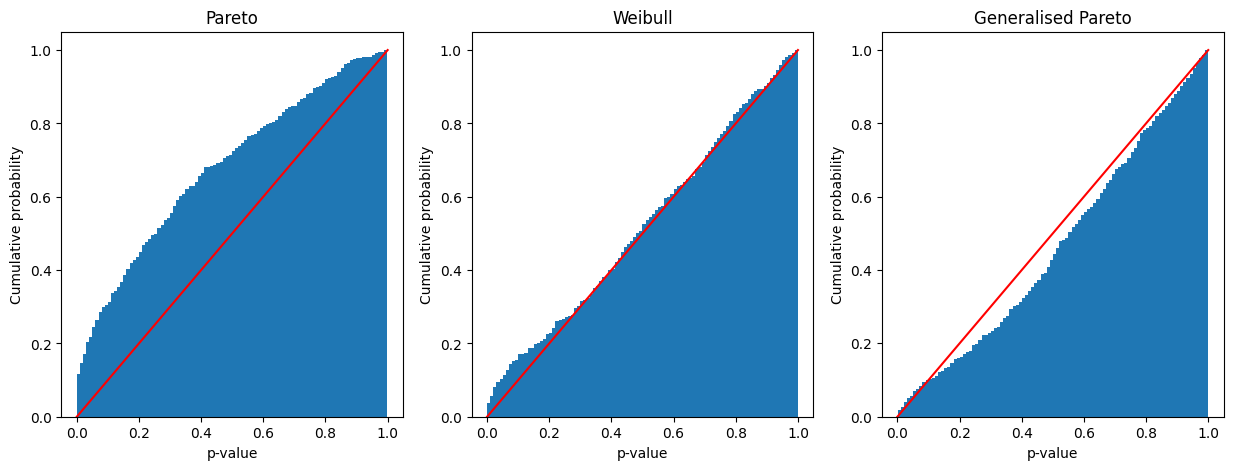

In [11]:
# Compare how often the null hypothesis is rejected for the 3 distributions
# Find the empirical distribution of the p-values for the 3 distributions
pareto_pvals = test_df.xs('Pareto', level='model_type')['KS_pval']
weibull_pvals = test_df.xs('Weibull', level='model_type')['KS_pval']
generalised_pareto_pvals = test_df.xs('GeneralisedPareto', level='model_type')['KS_pval']

# Plot the empirical cumulative distribution function of the p-values
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
n_bins = 100
ax[0].hist(pareto_pvals, bins=n_bins, cumulative=True, density=True)
x = np.linspace(0, 1, 100)
ax[0].plot(x, x, color='red')
ax[0].set_xlabel('p-value')
ax[0].set_ylabel('Cumulative probability')
ax[0].set_title('Pareto')
ax[1].hist(weibull_pvals, bins=n_bins, cumulative=True, density=True)
x = np.linspace(0, 1, 100)
ax[1].plot(x, x, color='red')
ax[1].set_xlabel('p-value')
ax[1].set_ylabel('Cumulative probability')
ax[1].set_title('Weibull')
ax[2].hist(generalised_pareto_pvals, bins=n_bins, cumulative=True, density=True)
x = np.linspace(0, 1, 100)
ax[2].plot(x, x, color='red')
ax[2].set_xlabel('p-value')
ax[2].set_ylabel('Cumulative probability')
ax[2].set_title('Generalised Pareto')
plt.show()



### Mean wealth prediction

In [12]:
path = "../../Stored_Results/bayesian_cross_sectional_regularised/mean_wealth_df.pkl"
rebuild = False
if os.path.exists(path) and not rebuild:
    with open(path, 'rb') as f:
        mean_wealth_df = dill.load(f)
else:
    mean_wealth = {}
    for group in groups:
        print(f"Calculating mean wealth for {group}")
        for model_type in ['Pareto', 'Weibull', 'GeneralisedPareto']:
            model = train_or_retrieve_regularised_cross_sectional_model(panel_df=df, group=group, model_type=model_type, retrain_if_saved=False)
            post_pred_df = model.posterior_predictive()
            years = df[df['group'] == group]['year'].unique()
            for year in years:
                post_pred = post_pred_df[f'y_{year}']
                mean_data = np.array(df[(df['year'] == year) & (df['group'] == group)]['net_worth'].iloc[0]).mean()
                mean_wealth[(year, group, model_type)] = {
                    'mean_data': mean_data,
                    'mean_model': post_pred.mean(),
                    'resid': mean_data - post_pred.mean(),
                    'abs_resid': np.abs(mean_data - post_pred.mean()),
                    'squared_resid': (mean_data - post_pred.mean())**2
                }
    mean_wealth_df = pd.DataFrame(mean_wealth).T
    mean_wealth_df.index.names = ['year', 'group', 'model_type']
    with open(path, 'wb') as f:
        dill.dump(mean_wealth_df, f)

Sampling: [y_1999, y_2000, y_2001, y_2002, y_2003, y_2004, y_2005, y_2006, y_2007, y_2008, y_2009, y_2010, y_2011, y_2012, y_2013, y_2014, y_2015, y_2016, y_2017, y_2018, y_2019, y_2020, y_2021, y_2022, y_2023]


Output()

Calculating mean wealth for Alps


Sampling: [y_1999, y_2000, y_2001, y_2002, y_2003, y_2004, y_2005, y_2006, y_2007, y_2008, y_2009, y_2010, y_2011, y_2012, y_2013, y_2014, y_2015, y_2016, y_2017, y_2018, y_2019, y_2020, y_2021, y_2022, y_2023]


Output()

Sampling: [y_1999, y_2000, y_2001, y_2002, y_2003, y_2004, y_2005, y_2006, y_2007, y_2008, y_2009, y_2010, y_2011, y_2012, y_2013, y_2014, y_2015, y_2016, y_2017, y_2018, y_2019, y_2020, y_2021, y_2022, y_2023]


Output()

Sampling: [y_2001, y_2002, y_2003, y_2004, y_2005, y_2006, y_2007, y_2008, y_2009, y_2010, y_2011, y_2012, y_2013, y_2014, y_2015, y_2016, y_2017, y_2018, y_2019, y_2020, y_2021, y_2022, y_2023]


Output()

Calculating mean wealth for Asian Islands


Sampling: [y_2001, y_2002, y_2003, y_2004, y_2005, y_2006, y_2007, y_2008, y_2009, y_2010, y_2011, y_2012, y_2013, y_2014, y_2015, y_2016, y_2017, y_2018, y_2019, y_2020, y_2021, y_2022, y_2023]


Output()

Sampling: [y_2001, y_2002, y_2003, y_2004, y_2005, y_2006, y_2007, y_2008, y_2009, y_2010, y_2011, y_2012, y_2013, y_2014, y_2015, y_2016, y_2017, y_2018, y_2019, y_2020, y_2021, y_2022, y_2023]


Output()

Sampling: [y_2001, y_2002, y_2003, y_2004, y_2005, y_2006, y_2007, y_2008, y_2009, y_2010, y_2011, y_2012, y_2013, y_2014, y_2015, y_2016, y_2017, y_2018, y_2019, y_2020, y_2021, y_2022, y_2023]


Output()

Calculating mean wealth for Australia


Sampling: [y_2001, y_2002, y_2003, y_2004, y_2005, y_2006, y_2007, y_2008, y_2009, y_2010, y_2011, y_2012, y_2013, y_2014, y_2015, y_2016, y_2017, y_2018, y_2019, y_2020, y_2021, y_2022, y_2023]


Output()

Sampling: [y_2001, y_2002, y_2003, y_2004, y_2005, y_2006, y_2007, y_2008, y_2009, y_2010, y_2011, y_2012, y_2013, y_2014, y_2015, y_2016, y_2017, y_2018, y_2019, y_2020, y_2021, y_2022, y_2023]


Output()

Sampling: [y_1999, y_2000, y_2001, y_2002, y_2003, y_2004, y_2005, y_2006, y_2007, y_2008, y_2009, y_2010, y_2011, y_2012, y_2013, y_2014, y_2015, y_2016, y_2017, y_2018, y_2019, y_2020, y_2021, y_2022, y_2023]


Output()

Calculating mean wealth for Brazil


Sampling: [y_1999, y_2000, y_2001, y_2002, y_2003, y_2004, y_2005, y_2006, y_2007, y_2008, y_2009, y_2010, y_2011, y_2012, y_2013, y_2014, y_2015, y_2016, y_2017, y_2018, y_2019, y_2020, y_2021, y_2022, y_2023]


Output()

Sampling: [y_1999, y_2000, y_2001, y_2002, y_2003, y_2004, y_2005, y_2006, y_2007, y_2008, y_2009, y_2010, y_2011, y_2012, y_2013, y_2014, y_2015, y_2016, y_2017, y_2018, y_2019, y_2020, y_2021, y_2022, y_2023]


Output()

Sampling: [y_2001, y_2002, y_2003, y_2004, y_2005, y_2006, y_2007, y_2008, y_2009, y_2010, y_2011, y_2012, y_2013, y_2014, y_2015, y_2016, y_2017, y_2018, y_2019, y_2020, y_2021, y_2022, y_2023]


Output()

Calculating mean wealth for British Islands


Sampling: [y_2001, y_2002, y_2003, y_2004, y_2005, y_2006, y_2007, y_2008, y_2009, y_2010, y_2011, y_2012, y_2013, y_2014, y_2015, y_2016, y_2017, y_2018, y_2019, y_2020, y_2021, y_2022, y_2023]


Output()

Sampling: [y_2001, y_2002, y_2003, y_2004, y_2005, y_2006, y_2007, y_2008, y_2009, y_2010, y_2011, y_2012, y_2013, y_2014, y_2015, y_2016, y_2017, y_2018, y_2019, y_2020, y_2021, y_2022, y_2023]


Output()

Sampling: [y_2001, y_2002, y_2003, y_2004, y_2005, y_2006, y_2007, y_2008, y_2009, y_2010, y_2011, y_2012, y_2013, y_2014, y_2015, y_2016, y_2017, y_2018, y_2019, y_2020, y_2021, y_2022, y_2023]


Output()

Calculating mean wealth for Canada


Sampling: [y_2001, y_2002, y_2003, y_2004, y_2005, y_2006, y_2007, y_2008, y_2009, y_2010, y_2011, y_2012, y_2013, y_2014, y_2015, y_2016, y_2017, y_2018, y_2019, y_2020, y_2021, y_2022, y_2023]


Output()

Sampling: [y_2001, y_2002, y_2003, y_2004, y_2005, y_2006, y_2007, y_2008, y_2009, y_2010, y_2011, y_2012, y_2013, y_2014, y_2015, y_2016, y_2017, y_2018, y_2019, y_2020, y_2021, y_2022, y_2023]


Output()

Sampling: [y_2001, y_2002, y_2003, y_2004, y_2005, y_2006, y_2007, y_2008, y_2009, y_2010, y_2011, y_2012, y_2013, y_2014, y_2015, y_2016, y_2017, y_2018, y_2019, y_2020, y_2021, y_2022, y_2023]


Output()

Calculating mean wealth for China


Sampling: [y_2001, y_2002, y_2003, y_2004, y_2005, y_2006, y_2007, y_2008, y_2009, y_2010, y_2011, y_2012, y_2013, y_2014, y_2015, y_2016, y_2017, y_2018, y_2019, y_2020, y_2021, y_2022, y_2023]


Output()

Sampling: [y_2001, y_2002, y_2003, y_2004, y_2005, y_2006, y_2007, y_2008, y_2009, y_2010, y_2011, y_2012, y_2013, y_2014, y_2015, y_2016, y_2017, y_2018, y_2019, y_2020, y_2021, y_2022, y_2023]


Output()

Sampling: [y_1999, y_2000, y_2001, y_2002, y_2003, y_2004, y_2005, y_2006, y_2007, y_2008, y_2009, y_2010, y_2011, y_2012, y_2013, y_2014, y_2015, y_2016, y_2017, y_2018, y_2019, y_2020, y_2021, y_2022, y_2023]


Output()

Calculating mean wealth for France


Sampling: [y_1999, y_2000, y_2001, y_2002, y_2003, y_2004, y_2005, y_2006, y_2007, y_2008, y_2009, y_2010, y_2011, y_2012, y_2013, y_2014, y_2015, y_2016, y_2017, y_2018, y_2019, y_2020, y_2021, y_2022, y_2023]


Output()

Sampling: [y_1999, y_2000, y_2001, y_2002, y_2003, y_2004, y_2005, y_2006, y_2007, y_2008, y_2009, y_2010, y_2011, y_2012, y_2013, y_2014, y_2015, y_2016, y_2017, y_2018, y_2019, y_2020, y_2021, y_2022, y_2023]


Output()

Sampling: [y_1999, y_2000, y_2001, y_2002, y_2003, y_2004, y_2005, y_2006, y_2007, y_2008, y_2009, y_2010, y_2011, y_2012, y_2013, y_2014, y_2015, y_2016, y_2017, y_2018, y_2019, y_2020, y_2021, y_2022, y_2023]


Output()

Calculating mean wealth for Germany


Sampling: [y_1999, y_2000, y_2001, y_2002, y_2003, y_2004, y_2005, y_2006, y_2007, y_2008, y_2009, y_2010, y_2011, y_2012, y_2013, y_2014, y_2015, y_2016, y_2017, y_2018, y_2019, y_2020, y_2021, y_2022, y_2023]


Output()

Sampling: [y_1999, y_2000, y_2001, y_2002, y_2003, y_2004, y_2005, y_2006, y_2007, y_2008, y_2009, y_2010, y_2011, y_2012, y_2013, y_2014, y_2015, y_2016, y_2017, y_2018, y_2019, y_2020, y_2021, y_2022, y_2023]


Output()

Calculating mean wealth for India


Sampling: [y_2001, y_2002, y_2003, y_2004, y_2005, y_2006, y_2007, y_2008, y_2009, y_2010, y_2011, y_2012, y_2013, y_2014, y_2015, y_2016, y_2017, y_2018, y_2019, y_2020, y_2021, y_2022, y_2023]


Output()

Sampling: [y_2001, y_2002, y_2003, y_2004, y_2005, y_2006, y_2007, y_2008, y_2009, y_2010, y_2011, y_2012, y_2013, y_2014, y_2015, y_2016, y_2017, y_2018, y_2019, y_2020, y_2021, y_2022, y_2023]


Output()

Sampling: [y_2001, y_2002, y_2003, y_2004, y_2005, y_2006, y_2007, y_2008, y_2009, y_2010, y_2011, y_2012, y_2013, y_2014, y_2015, y_2016, y_2017, y_2018, y_2019, y_2020, y_2021, y_2022, y_2023]


Output()

Sampling: [y_2001, y_2002, y_2003, y_2004, y_2005, y_2006, y_2007, y_2008, y_2009, y_2010, y_2011, y_2012, y_2013, y_2014, y_2015, y_2016, y_2017, y_2018, y_2019, y_2020, y_2021, y_2022, y_2023]


Output()

Calculating mean wealth for Israel + Turkey


Sampling: [y_2001, y_2002, y_2003, y_2004, y_2005, y_2006, y_2007, y_2008, y_2009, y_2010, y_2011, y_2012, y_2013, y_2014, y_2015, y_2016, y_2017, y_2018, y_2019, y_2020, y_2021, y_2022, y_2023]


Output()

Sampling: [y_2001, y_2002, y_2003, y_2004, y_2005, y_2006, y_2007, y_2008, y_2009, y_2010, y_2011, y_2012, y_2013, y_2014, y_2015, y_2016, y_2017, y_2018, y_2019, y_2020, y_2021, y_2022, y_2023]


Output()

Sampling: [y_2001, y_2002, y_2003, y_2004, y_2005, y_2006, y_2007, y_2008, y_2009, y_2010, y_2011, y_2012, y_2013, y_2014, y_2015, y_2016, y_2017, y_2018, y_2019, y_2020, y_2021, y_2022, y_2023]


Output()

Calculating mean wealth for Italy


Sampling: [y_2001, y_2002, y_2003, y_2004, y_2005, y_2006, y_2007, y_2008, y_2009, y_2010, y_2011, y_2012, y_2013, y_2014, y_2015, y_2016, y_2017, y_2018, y_2019, y_2020, y_2021, y_2022, y_2023]


Output()

Sampling: [y_2001, y_2002, y_2003, y_2004, y_2005, y_2006, y_2007, y_2008, y_2009, y_2010, y_2011, y_2012, y_2013, y_2014, y_2015, y_2016, y_2017, y_2018, y_2019, y_2020, y_2021, y_2022, y_2023]


Output()

Sampling: [y_2000, y_2001, y_2002, y_2003, y_2004, y_2005, y_2006, y_2007, y_2008, y_2009, y_2010, y_2011, y_2012, y_2013, y_2014, y_2015, y_2016, y_2017, y_2018, y_2019, y_2020, y_2021, y_2022, y_2023]


Output()

Calculating mean wealth for Japan


Sampling: [y_2000, y_2001, y_2002, y_2003, y_2004, y_2005, y_2006, y_2007, y_2008, y_2009, y_2010, y_2011, y_2012, y_2013, y_2014, y_2015, y_2016, y_2017, y_2018, y_2019, y_2020, y_2021, y_2022, y_2023]


Output()

Sampling: [y_2000, y_2001, y_2002, y_2003, y_2004, y_2005, y_2006, y_2007, y_2008, y_2009, y_2010, y_2011, y_2012, y_2013, y_2014, y_2015, y_2016, y_2017, y_2018, y_2019, y_2020, y_2021, y_2022, y_2023]


Output()

Sampling: [y_2001, y_2002, y_2003, y_2004, y_2005, y_2006, y_2007, y_2008, y_2009, y_2010, y_2011, y_2012, y_2013, y_2014, y_2015, y_2016, y_2017, y_2018, y_2019, y_2020, y_2021, y_2022, y_2023]


Output()

Calculating mean wealth for Russia


Sampling: [y_2001, y_2002, y_2003, y_2004, y_2005, y_2006, y_2007, y_2008, y_2009, y_2010, y_2011, y_2012, y_2013, y_2014, y_2015, y_2016, y_2017, y_2018, y_2019, y_2020, y_2021, y_2022, y_2023]


Output()

Sampling: [y_2001, y_2002, y_2003, y_2004, y_2005, y_2006, y_2007, y_2008, y_2009, y_2010, y_2011, y_2012, y_2013, y_2014, y_2015, y_2016, y_2017, y_2018, y_2019, y_2020, y_2021, y_2022, y_2023]


Output()

Calculating mean wealth for Scandinavia


Sampling: [y_2000, y_2001, y_2002, y_2003, y_2004, y_2005, y_2006, y_2007, y_2008, y_2009, y_2010, y_2011, y_2012, y_2013, y_2014, y_2015, y_2016, y_2017, y_2018, y_2019, y_2020, y_2021, y_2022, y_2023]


Output()

Sampling: [y_2000, y_2001, y_2002, y_2003, y_2004, y_2005, y_2006, y_2007, y_2008, y_2009, y_2010, y_2011, y_2012, y_2013, y_2014, y_2015, y_2016, y_2017, y_2018, y_2019, y_2020, y_2021, y_2022, y_2023]


Output()

Sampling: [y_2000, y_2001, y_2002, y_2003, y_2004, y_2005, y_2006, y_2007, y_2008, y_2009, y_2010, y_2011, y_2012, y_2013, y_2014, y_2015, y_2016, y_2017, y_2018, y_2019, y_2020, y_2021, y_2022, y_2023]


Output()

Sampling: [y_2001, y_2002, y_2003, y_2004, y_2005, y_2006, y_2007, y_2008, y_2009, y_2010, y_2011, y_2012, y_2013, y_2014, y_2015, y_2016, y_2017, y_2018, y_2019, y_2020, y_2021, y_2022, y_2023]


Output()

Calculating mean wealth for South Korea


Sampling: [y_2001, y_2002, y_2003, y_2004, y_2005, y_2006, y_2007, y_2008, y_2009, y_2010, y_2011, y_2012, y_2013, y_2014, y_2015, y_2016, y_2017, y_2018, y_2019, y_2020, y_2021, y_2022, y_2023]


Output()

Sampling: [y_2001, y_2002, y_2003, y_2004, y_2005, y_2006, y_2007, y_2008, y_2009, y_2010, y_2011, y_2012, y_2013, y_2014, y_2015, y_2016, y_2017, y_2018, y_2019, y_2020, y_2021, y_2022, y_2023]


Output()

Sampling: [y_2001, y_2002, y_2003, y_2004, y_2005, y_2006, y_2007, y_2008, y_2009, y_2010, y_2011, y_2012, y_2013, y_2014, y_2015, y_2016, y_2017, y_2018, y_2019, y_2020, y_2021, y_2022, y_2023]


Output()

Calculating mean wealth for Southeast Asia


Sampling: [y_2001, y_2002, y_2003, y_2004, y_2005, y_2006, y_2007, y_2008, y_2009, y_2010, y_2011, y_2012, y_2013, y_2014, y_2015, y_2016, y_2017, y_2018, y_2019, y_2020, y_2021, y_2022, y_2023]


Output()

Sampling: [y_2001, y_2002, y_2003, y_2004, y_2005, y_2006, y_2007, y_2008, y_2009, y_2010, y_2011, y_2012, y_2013, y_2014, y_2015, y_2016, y_2017, y_2018, y_2019, y_2020, y_2021, y_2022, y_2023]


Output()

Calculating mean wealth for U.S.


Sampling: [y_2001, y_2002, y_2003, y_2004, y_2005, y_2006, y_2007, y_2008, y_2009, y_2010, y_2011, y_2012, y_2013, y_2014, y_2015, y_2016, y_2017, y_2018, y_2019, y_2020, y_2021, y_2022, y_2023]


Output()

Sampling: [y_2001, y_2002, y_2003, y_2004, y_2005, y_2006, y_2007, y_2008, y_2009, y_2010, y_2011, y_2012, y_2013, y_2014, y_2015, y_2016, y_2017, y_2018, y_2019, y_2020, y_2021, y_2022, y_2023]


Output()

Sampling: [y_2001, y_2002, y_2003, y_2004, y_2005, y_2006, y_2007, y_2008, y_2009, y_2010, y_2011, y_2012, y_2013, y_2014, y_2015, y_2016, y_2017, y_2018, y_2019, y_2020, y_2021, y_2022, y_2023]


Output()

In [13]:
mean_wealth_df

,,,mean_data,mean_model,resid,abs_resid,squared_resid
year,group,model_type,,,,,
1999,Alps,Pareto,2.900000,17.837978,-14.937978,14.937978,223.143173
2000,Alps,Pareto,1.900000,16.704132,-14.804132,14.804132,219.162317
2001,Alps,Pareto,4.042857,31.327285,-27.284428,27.284428,744.439985
2002,Alps,Pareto,3.950000,25.538523,-21.588523,21.588523,466.064317
2003,Alps,Pareto,2.428571,30.648143,-28.219572,28.219572,796.344233
...,...,...,...,...,...,...,...
2018,U.S.,GeneralisedPareto,5.287884,5.408475,-0.120591,0.120591,0.014542
2019,U.S.,GeneralisedPareto,5.125206,5.570935,-0.445729,0.445729,0.198675
2020,U.S.,GeneralisedPareto,4.794634,4.497501,0.297133,0.297133,0.088288


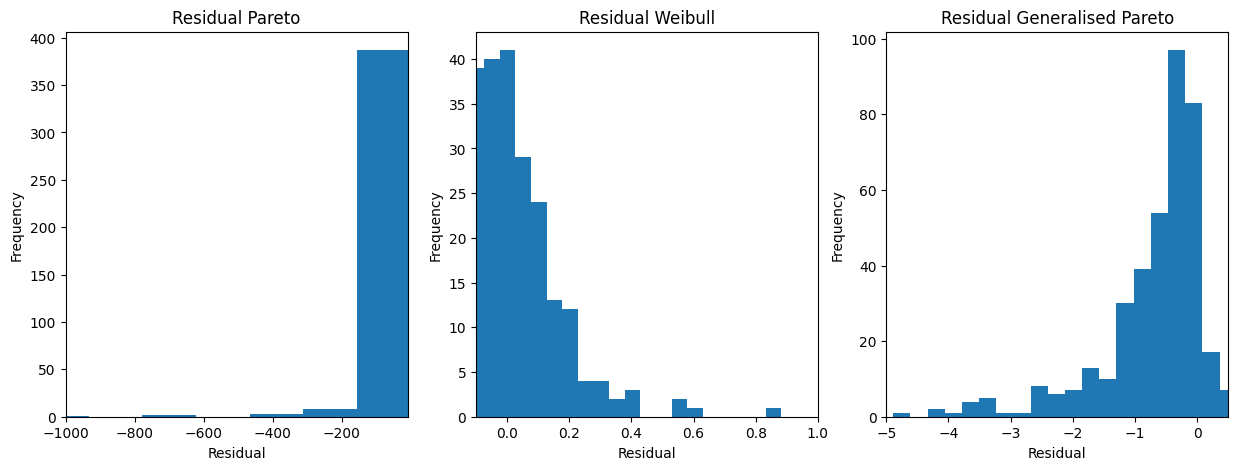

In [14]:
# Plot the residuals for the 3 distributions
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
n_bins = 100
ax[0].hist(mean_wealth_df.xs('Pareto', level='model_type')['resid'], bins=n_bins)
ax[0].set_xlim(-1000, -10)
ax[0].set_xlabel('Residual')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Residual Pareto')
ax[1].hist(mean_wealth_df.xs('Weibull', level='model_type')['resid'], bins=n_bins)
ax[1].set_xlim(-0.1, 1.0)
ax[1].set_xlabel('Residual')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Residual Weibull')
ax[2].hist(mean_wealth_df.xs('GeneralisedPareto', level='model_type')['resid'], bins=n_bins)
ax[2].set_xlim(-5, 0.5)
ax[2].set_xlabel('Residual')
ax[2].set_ylabel('Frequency')
ax[2].set_title('Residual Generalised Pareto')
plt.show()

In [15]:
# find the average absolute residuals by country/distribution:
without_pareto = mean_wealth_df[mean_wealth_df.index.get_level_values('model_type') != 'Pareto']
grouped_mean_wealth = without_pareto.groupby(['group', 'model_type']).mean()

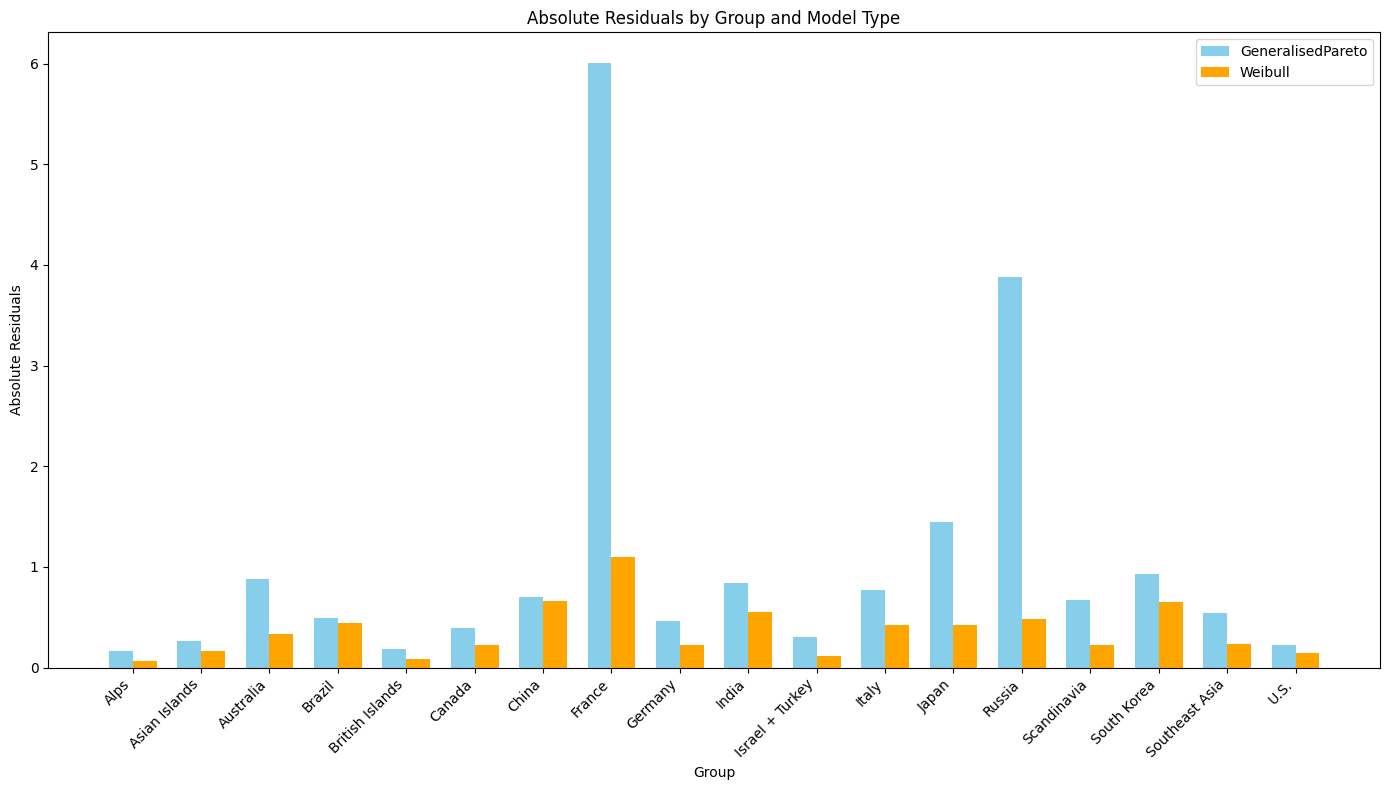

In [16]:
# Plotting the bar plot for abs_resid column
fig, ax = plt.subplots(figsize=(14, 8))

# Extract data for plotting
groups = grouped_mean_wealth.index.get_level_values('group').unique()
x = np.arange(len(groups))  # the label locations
width = 0.35  # the width of the bars

# Data for bars
generalised_pareto_resid = grouped_mean_wealth.xs('GeneralisedPareto', level='model_type')['abs_resid']
weibull_resid = grouped_mean_wealth.xs('Weibull', level='model_type')['abs_resid']

# Plot bars
rects1 = ax.bar(x - width/2, generalised_pareto_resid, width, label='GeneralisedPareto', color='skyblue')
rects2 = ax.bar(x + width/2, weibull_resid, width, label='Weibull', color='orange')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Group')
ax.set_ylabel('Absolute Residuals')
ax.set_title('Absolute Residuals by Group and Model Type')
ax.set_xticks(x)
ax.set_xticklabels(groups, rotation=45, ha="right")
ax.legend()

fig.tight_layout()

# Display the plot
plt.show()

In [17]:
grouped_by_year_mean_wealth = without_pareto.groupby(['year', 'model_type']).median()

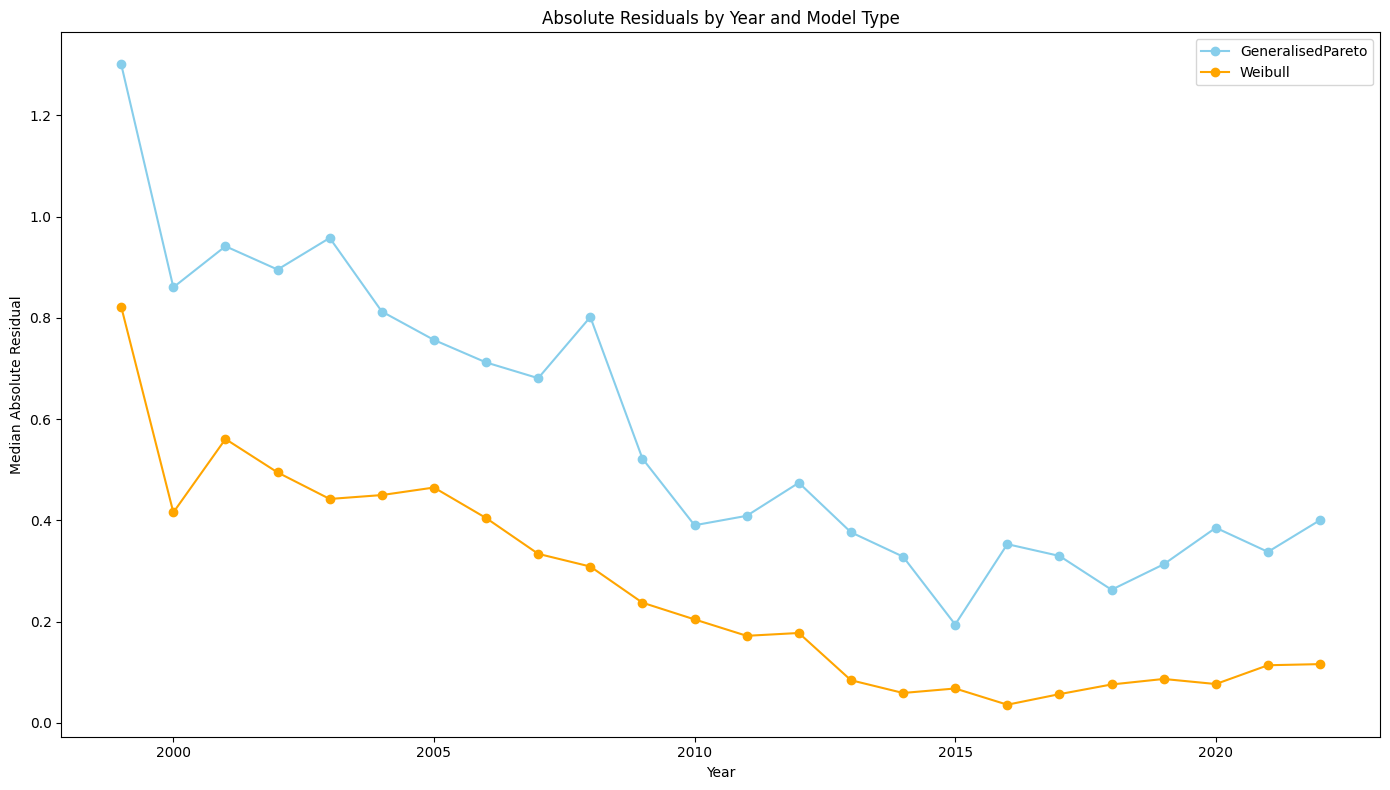

In [18]:
# Plotting the line plot for abs_resid column
fig, ax = plt.subplots(figsize=(14, 8))

# Extract data for plotting
years = grouped_by_year_mean_wealth.index.get_level_values('year').unique()

# Data for lines
generalised_pareto_resid = grouped_by_year_mean_wealth.xs('GeneralisedPareto', level='model_type')['abs_resid']
weibull_resid = grouped_by_year_mean_wealth.xs('Weibull', level='model_type')['abs_resid']

# Plot lines
ax.plot(years, generalised_pareto_resid, label='GeneralisedPareto', color='skyblue', marker='o')
ax.plot(years, weibull_resid, label='Weibull', color='orange', marker='o')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Year')
ax.set_ylabel('Median Absolute Residual')
ax.set_title('Absolute Residuals by Year and Model Type')
ax.legend()

fig.tight_layout()

# Display the plot
plt.show()